In [1]:
# magic output of plotting commands is displayed inline
%matplotlib inline

# import packages, framework and libraries 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# import Zalando's MNIST-alike dataset
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data-fashion/fashion')


Extracting data-fashion/fashion/train-images-idx3-ubyte.gz
Extracting data-fashion/fashion/train-labels-idx1-ubyte.gz
Extracting data-fashion/fashion/t10k-images-idx3-ubyte.gz
Extracting data-fashion/fashion/t10k-labels-idx1-ubyte.gz


55000


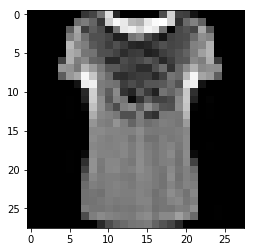

In [2]:
print(len(data.train.images))

img = data.train.images[1]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [3]:
# Define placeholders, no size for batch defined so None, and images are MNIST alike 28x28 greyscale
inputs = tf.placeholder(tf.float32, (None, 28,28, 1), name='inputs')
targets = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

In [4]:
# Encoder (from 28x28x1 --> 4x4x8), the compressed represetation is going to be a pooling layer
# we don't want to potentially loose information padding --> same
# since we want a reduced representation of the image, we try a bigger 
# filter (feature map) initally and we gradually reduce it at each convolution

### Encoder
# Conv 1 + Maxpool
conv1 = tf.layers.conv2d(inputs, 64, (2,2), padding='same', activation=tf.nn.relu) # 28x28x64
# tuples for maxpool layer: pool_size and strides
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same') # 14x14x64
# Conv 2 + Maxpool
conv2 = tf.layers.conv2d(maxpool1, 32, (2,2), padding='same', activation=tf.nn.relu) # 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same') # 7x7x32
# Conv 3 + Maxpool 
conv3 = tf.layers.conv2d(maxpool2, 16, (1,1), padding='same', activation=tf.nn.relu) # 7x7x16
maxpool3 = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same') # 4x4x16
# Conv 4 + Maxpool
conv4 = tf.layers.conv2d(maxpool3, 8, (1,1), padding='same', activation=tf.nn.relu) # 4x4x8
maxpool4 = tf.layers.max_pooling2d(conv4, (2,2), (2,2), padding='same') # 2x2x8
# Conv
conv5 = tf.layers.conv2d(maxpool4, 4, (1,1), padding='same', activation=tf.nn.relu) # 2x2x4
encoded = tf.layers.max_pooling2d(conv5, (2,2), (1,1), padding='same') # 2x2x4
print(encoded.shape) # (?, 2, 2, 4)

(?, 2, 2, 4)


In [5]:
### Alternative encoder 

from custom_convolution_model import *

tf.reset_default_graph()
logits = encoding_conv_net(inputs)

In [6]:
### Decoder

# Resize images to size using nearest neighbor interpolation
upsample1 = tf.image.resize_nearest_neighbor(logits, (4,4)) # 4x4x4 
deconv1 = tf.layers.conv2d(upsample1, 8, (2,2), padding='same', activation=tf.nn.relu) # 4x4x8
upsample2 = tf.image.resize_nearest_neighbor(deconv1, (7,7)) # 7x7x8 
deconv2 = tf.layers.conv2d(upsample2, 16, (2,2), padding='same', activation=tf.nn.relu) # 7x7x16
upsample3 = tf.image.resize_nearest_neighbor(deconv2, (14,14)) # 14x14x8
deconv3 = tf.layers.conv2d(upsample3, 32, (2,2), padding='same', activation=tf.nn.relu) # 14x14x32
upsample4 = tf.image.resize_nearest_neighbor(deconv3, (28,28)) # 28x28x8
deconv4 = tf.layers.conv2d(upsample4, 64, (3,3), padding='same', activation=tf.nn.relu) # 28x28x64
print(deconv4.shape)

(?, 28, 28, 64)


In [7]:
# Hyperparameters 
lr = 0.001
 
# output layer 28x28x1
output = tf.layers.conv2d(deconv4, 1, (2,2), padding='same', activation=None) #logits 
decoded = tf.nn.sigmoid(output, name='decoded')

# compute the distance output vs target
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets, logits=output)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate = lr).minimize(cost)    

In [8]:
sess = tf.Session()

In [9]:
epochs = 20
batch_size = 300
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(len(data.train.images) // batch_size): 
        batch = data.train.next_batch(batch_size)
        
        # https://stackoverflow.com/questions/41848660/why-the-negative-reshape-1-in-mnist-tutorial
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _= sess.run([cost, opt], feed_dict={inputs: imgs, targets: imgs})
        
        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))
        

Epoch: 1/20... Training loss: 0.6932
Epoch: 1/20... Training loss: 0.6919
Epoch: 1/20... Training loss: 0.6904
Epoch: 1/20... Training loss: 0.6891
Epoch: 1/20... Training loss: 0.6873
Epoch: 1/20... Training loss: 0.6851
Epoch: 1/20... Training loss: 0.6817
Epoch: 1/20... Training loss: 0.6799
Epoch: 1/20... Training loss: 0.6769
Epoch: 1/20... Training loss: 0.6725
Epoch: 1/20... Training loss: 0.6679
Epoch: 1/20... Training loss: 0.6662
Epoch: 1/20... Training loss: 0.6622
Epoch: 1/20... Training loss: 0.6517
Epoch: 1/20... Training loss: 0.6453
Epoch: 1/20... Training loss: 0.6390
Epoch: 1/20... Training loss: 0.6310
Epoch: 1/20... Training loss: 0.6370
Epoch: 1/20... Training loss: 0.6275
Epoch: 1/20... Training loss: 0.6311
Epoch: 1/20... Training loss: 0.6377
Epoch: 1/20... Training loss: 0.6372
Epoch: 1/20... Training loss: 0.6216
Epoch: 1/20... Training loss: 0.6210
Epoch: 1/20... Training loss: 0.6301
Epoch: 1/20... Training loss: 0.6209
Epoch: 1/20... Training loss: 0.6095
E

Epoch: 2/20... Training loss: 0.4602
Epoch: 2/20... Training loss: 0.4643
Epoch: 2/20... Training loss: 0.4668
Epoch: 2/20... Training loss: 0.4612
Epoch: 2/20... Training loss: 0.4644
Epoch: 2/20... Training loss: 0.4735
Epoch: 2/20... Training loss: 0.4721
Epoch: 2/20... Training loss: 0.4639
Epoch: 2/20... Training loss: 0.4639
Epoch: 2/20... Training loss: 0.4633
Epoch: 2/20... Training loss: 0.4743
Epoch: 2/20... Training loss: 0.4753
Epoch: 2/20... Training loss: 0.4705
Epoch: 2/20... Training loss: 0.4553
Epoch: 2/20... Training loss: 0.4734
Epoch: 2/20... Training loss: 0.4743
Epoch: 2/20... Training loss: 0.4780
Epoch: 2/20... Training loss: 0.4640
Epoch: 2/20... Training loss: 0.4625
Epoch: 2/20... Training loss: 0.4652
Epoch: 2/20... Training loss: 0.4729
Epoch: 2/20... Training loss: 0.4627
Epoch: 2/20... Training loss: 0.4768
Epoch: 2/20... Training loss: 0.4721
Epoch: 2/20... Training loss: 0.4679
Epoch: 2/20... Training loss: 0.4675
Epoch: 2/20... Training loss: 0.4760
E

Epoch: 3/20... Training loss: 0.4543
Epoch: 3/20... Training loss: 0.4602
Epoch: 3/20... Training loss: 0.4639
Epoch: 3/20... Training loss: 0.4483
Epoch: 3/20... Training loss: 0.4461
Epoch: 3/20... Training loss: 0.4522
Epoch: 3/20... Training loss: 0.4544
Epoch: 3/20... Training loss: 0.4657
Epoch: 3/20... Training loss: 0.4550
Epoch: 3/20... Training loss: 0.4502
Epoch: 3/20... Training loss: 0.4493
Epoch: 3/20... Training loss: 0.4505
Epoch: 3/20... Training loss: 0.4609
Epoch: 3/20... Training loss: 0.4576
Epoch: 3/20... Training loss: 0.4672
Epoch: 3/20... Training loss: 0.4573
Epoch: 3/20... Training loss: 0.4543
Epoch: 3/20... Training loss: 0.4522
Epoch: 3/20... Training loss: 0.4592
Epoch: 3/20... Training loss: 0.4578
Epoch: 3/20... Training loss: 0.4564
Epoch: 3/20... Training loss: 0.4367
Epoch: 3/20... Training loss: 0.4607
Epoch: 3/20... Training loss: 0.4598
Epoch: 3/20... Training loss: 0.4504
Epoch: 3/20... Training loss: 0.4522
Epoch: 3/20... Training loss: 0.4503
E

Epoch: 4/20... Training loss: 0.4528
Epoch: 4/20... Training loss: 0.4607
Epoch: 4/20... Training loss: 0.4555
Epoch: 4/20... Training loss: 0.4545
Epoch: 4/20... Training loss: 0.4581
Epoch: 4/20... Training loss: 0.4466
Epoch: 4/20... Training loss: 0.4485
Epoch: 4/20... Training loss: 0.4546
Epoch: 4/20... Training loss: 0.4475
Epoch: 4/20... Training loss: 0.4533
Epoch: 4/20... Training loss: 0.4540
Epoch: 4/20... Training loss: 0.4578
Epoch: 4/20... Training loss: 0.4661
Epoch: 4/20... Training loss: 0.4460
Epoch: 4/20... Training loss: 0.4499
Epoch: 4/20... Training loss: 0.4595
Epoch: 4/20... Training loss: 0.4535
Epoch: 4/20... Training loss: 0.4540
Epoch: 4/20... Training loss: 0.4611
Epoch: 4/20... Training loss: 0.4552
Epoch: 4/20... Training loss: 0.4483
Epoch: 4/20... Training loss: 0.4414
Epoch: 4/20... Training loss: 0.4451
Epoch: 4/20... Training loss: 0.4515
Epoch: 4/20... Training loss: 0.4517
Epoch: 4/20... Training loss: 0.4502
Epoch: 4/20... Training loss: 0.4500
E

Epoch: 5/20... Training loss: 0.4403
Epoch: 5/20... Training loss: 0.4399
Epoch: 5/20... Training loss: 0.4509
Epoch: 5/20... Training loss: 0.4443
Epoch: 5/20... Training loss: 0.4491
Epoch: 5/20... Training loss: 0.4438
Epoch: 5/20... Training loss: 0.4451
Epoch: 5/20... Training loss: 0.4473
Epoch: 5/20... Training loss: 0.4522
Epoch: 5/20... Training loss: 0.4513
Epoch: 5/20... Training loss: 0.4409
Epoch: 5/20... Training loss: 0.4535
Epoch: 5/20... Training loss: 0.4474
Epoch: 5/20... Training loss: 0.4432
Epoch: 5/20... Training loss: 0.4530
Epoch: 5/20... Training loss: 0.4544
Epoch: 5/20... Training loss: 0.4534
Epoch: 5/20... Training loss: 0.4477
Epoch: 5/20... Training loss: 0.4539
Epoch: 5/20... Training loss: 0.4483
Epoch: 5/20... Training loss: 0.4560
Epoch: 5/20... Training loss: 0.4401
Epoch: 6/20... Training loss: 0.4442
Epoch: 6/20... Training loss: 0.4449
Epoch: 6/20... Training loss: 0.4349
Epoch: 6/20... Training loss: 0.4476
Epoch: 6/20... Training loss: 0.4431
E

Epoch: 7/20... Training loss: 0.4373
Epoch: 7/20... Training loss: 0.4495
Epoch: 7/20... Training loss: 0.4539
Epoch: 7/20... Training loss: 0.4424
Epoch: 7/20... Training loss: 0.4444
Epoch: 7/20... Training loss: 0.4373
Epoch: 7/20... Training loss: 0.4460
Epoch: 7/20... Training loss: 0.4566
Epoch: 7/20... Training loss: 0.4398
Epoch: 7/20... Training loss: 0.4516
Epoch: 7/20... Training loss: 0.4429
Epoch: 7/20... Training loss: 0.4520
Epoch: 7/20... Training loss: 0.4547
Epoch: 7/20... Training loss: 0.4534
Epoch: 7/20... Training loss: 0.4468
Epoch: 7/20... Training loss: 0.4417
Epoch: 7/20... Training loss: 0.4498
Epoch: 7/20... Training loss: 0.4379
Epoch: 7/20... Training loss: 0.4527
Epoch: 7/20... Training loss: 0.4482
Epoch: 7/20... Training loss: 0.4328
Epoch: 7/20... Training loss: 0.4358
Epoch: 7/20... Training loss: 0.4476
Epoch: 7/20... Training loss: 0.4478
Epoch: 7/20... Training loss: 0.4451
Epoch: 7/20... Training loss: 0.4484
Epoch: 7/20... Training loss: 0.4538
E

Epoch: 8/20... Training loss: 0.4468
Epoch: 8/20... Training loss: 0.4436
Epoch: 8/20... Training loss: 0.4401
Epoch: 8/20... Training loss: 0.4383
Epoch: 8/20... Training loss: 0.4389
Epoch: 8/20... Training loss: 0.4375
Epoch: 8/20... Training loss: 0.4461
Epoch: 8/20... Training loss: 0.4453
Epoch: 8/20... Training loss: 0.4531
Epoch: 8/20... Training loss: 0.4540
Epoch: 8/20... Training loss: 0.4451
Epoch: 8/20... Training loss: 0.4424
Epoch: 8/20... Training loss: 0.4426
Epoch: 8/20... Training loss: 0.4399
Epoch: 8/20... Training loss: 0.4351
Epoch: 8/20... Training loss: 0.4612
Epoch: 8/20... Training loss: 0.4520
Epoch: 8/20... Training loss: 0.4463
Epoch: 8/20... Training loss: 0.4430
Epoch: 8/20... Training loss: 0.4393
Epoch: 8/20... Training loss: 0.4436
Epoch: 8/20... Training loss: 0.4456
Epoch: 8/20... Training loss: 0.4415
Epoch: 8/20... Training loss: 0.4476
Epoch: 8/20... Training loss: 0.4423
Epoch: 8/20... Training loss: 0.4467
Epoch: 8/20... Training loss: 0.4442
E

Epoch: 9/20... Training loss: 0.4530
Epoch: 9/20... Training loss: 0.4488
Epoch: 9/20... Training loss: 0.4473
Epoch: 9/20... Training loss: 0.4424
Epoch: 9/20... Training loss: 0.4408
Epoch: 9/20... Training loss: 0.4379
Epoch: 9/20... Training loss: 0.4419
Epoch: 9/20... Training loss: 0.4463
Epoch: 9/20... Training loss: 0.4479
Epoch: 9/20... Training loss: 0.4348
Epoch: 9/20... Training loss: 0.4514
Epoch: 9/20... Training loss: 0.4387
Epoch: 9/20... Training loss: 0.4479
Epoch: 9/20... Training loss: 0.4422
Epoch: 9/20... Training loss: 0.4494
Epoch: 9/20... Training loss: 0.4398
Epoch: 9/20... Training loss: 0.4494
Epoch: 9/20... Training loss: 0.4534
Epoch: 9/20... Training loss: 0.4351
Epoch: 9/20... Training loss: 0.4447
Epoch: 9/20... Training loss: 0.4372
Epoch: 9/20... Training loss: 0.4511
Epoch: 9/20... Training loss: 0.4429
Epoch: 9/20... Training loss: 0.4346
Epoch: 9/20... Training loss: 0.4419
Epoch: 9/20... Training loss: 0.4507
Epoch: 9/20... Training loss: 0.4421
E

Epoch: 10/20... Training loss: 0.4530
Epoch: 10/20... Training loss: 0.4495
Epoch: 10/20... Training loss: 0.4460
Epoch: 10/20... Training loss: 0.4387
Epoch: 10/20... Training loss: 0.4352
Epoch: 10/20... Training loss: 0.4513
Epoch: 10/20... Training loss: 0.4491
Epoch: 10/20... Training loss: 0.4351
Epoch: 10/20... Training loss: 0.4489
Epoch: 10/20... Training loss: 0.4474
Epoch: 10/20... Training loss: 0.4463
Epoch: 10/20... Training loss: 0.4410
Epoch: 10/20... Training loss: 0.4384
Epoch: 10/20... Training loss: 0.4459
Epoch: 10/20... Training loss: 0.4428
Epoch: 10/20... Training loss: 0.4436
Epoch: 10/20... Training loss: 0.4477
Epoch: 10/20... Training loss: 0.4381
Epoch: 10/20... Training loss: 0.4523
Epoch: 10/20... Training loss: 0.4444
Epoch: 10/20... Training loss: 0.4436
Epoch: 10/20... Training loss: 0.4509
Epoch: 10/20... Training loss: 0.4447
Epoch: 10/20... Training loss: 0.4382
Epoch: 10/20... Training loss: 0.4458
Epoch: 10/20... Training loss: 0.4359
Epoch: 10/20

Epoch: 11/20... Training loss: 0.4497
Epoch: 11/20... Training loss: 0.4516
Epoch: 11/20... Training loss: 0.4280
Epoch: 11/20... Training loss: 0.4472
Epoch: 11/20... Training loss: 0.4408
Epoch: 11/20... Training loss: 0.4379
Epoch: 11/20... Training loss: 0.4499
Epoch: 11/20... Training loss: 0.4485
Epoch: 11/20... Training loss: 0.4387
Epoch: 11/20... Training loss: 0.4322
Epoch: 11/20... Training loss: 0.4493
Epoch: 11/20... Training loss: 0.4402
Epoch: 11/20... Training loss: 0.4494
Epoch: 12/20... Training loss: 0.4396
Epoch: 12/20... Training loss: 0.4417
Epoch: 12/20... Training loss: 0.4418
Epoch: 12/20... Training loss: 0.4366
Epoch: 12/20... Training loss: 0.4349
Epoch: 12/20... Training loss: 0.4418
Epoch: 12/20... Training loss: 0.4417
Epoch: 12/20... Training loss: 0.4419
Epoch: 12/20... Training loss: 0.4551
Epoch: 12/20... Training loss: 0.4420
Epoch: 12/20... Training loss: 0.4485
Epoch: 12/20... Training loss: 0.4349
Epoch: 12/20... Training loss: 0.4424
Epoch: 12/20

Epoch: 13/20... Training loss: 0.4388
Epoch: 13/20... Training loss: 0.4361
Epoch: 13/20... Training loss: 0.4482
Epoch: 13/20... Training loss: 0.4473
Epoch: 13/20... Training loss: 0.4485
Epoch: 13/20... Training loss: 0.4415
Epoch: 13/20... Training loss: 0.4363
Epoch: 13/20... Training loss: 0.4398
Epoch: 13/20... Training loss: 0.4474
Epoch: 13/20... Training loss: 0.4419
Epoch: 13/20... Training loss: 0.4398
Epoch: 13/20... Training loss: 0.4426
Epoch: 13/20... Training loss: 0.4413
Epoch: 13/20... Training loss: 0.4474
Epoch: 13/20... Training loss: 0.4388
Epoch: 13/20... Training loss: 0.4425
Epoch: 13/20... Training loss: 0.4462
Epoch: 13/20... Training loss: 0.4429
Epoch: 13/20... Training loss: 0.4430
Epoch: 13/20... Training loss: 0.4451
Epoch: 13/20... Training loss: 0.4378
Epoch: 13/20... Training loss: 0.4432
Epoch: 13/20... Training loss: 0.4368
Epoch: 13/20... Training loss: 0.4515
Epoch: 13/20... Training loss: 0.4380
Epoch: 13/20... Training loss: 0.4446
Epoch: 13/20

Epoch: 14/20... Training loss: 0.4360
Epoch: 14/20... Training loss: 0.4341
Epoch: 14/20... Training loss: 0.4335
Epoch: 14/20... Training loss: 0.4445
Epoch: 14/20... Training loss: 0.4414
Epoch: 14/20... Training loss: 0.4448
Epoch: 14/20... Training loss: 0.4515
Epoch: 14/20... Training loss: 0.4329
Epoch: 14/20... Training loss: 0.4428
Epoch: 14/20... Training loss: 0.4409
Epoch: 14/20... Training loss: 0.4497
Epoch: 14/20... Training loss: 0.4393
Epoch: 14/20... Training loss: 0.4445
Epoch: 14/20... Training loss: 0.4529
Epoch: 14/20... Training loss: 0.4397
Epoch: 14/20... Training loss: 0.4449
Epoch: 14/20... Training loss: 0.4524
Epoch: 14/20... Training loss: 0.4387
Epoch: 14/20... Training loss: 0.4352
Epoch: 14/20... Training loss: 0.4424
Epoch: 14/20... Training loss: 0.4421
Epoch: 14/20... Training loss: 0.4548
Epoch: 14/20... Training loss: 0.4456
Epoch: 14/20... Training loss: 0.4539
Epoch: 14/20... Training loss: 0.4445
Epoch: 14/20... Training loss: 0.4524
Epoch: 14/20

Epoch: 15/20... Training loss: 0.4419
Epoch: 15/20... Training loss: 0.4373
Epoch: 15/20... Training loss: 0.4429
Epoch: 15/20... Training loss: 0.4396
Epoch: 15/20... Training loss: 0.4418
Epoch: 15/20... Training loss: 0.4499
Epoch: 15/20... Training loss: 0.4382
Epoch: 15/20... Training loss: 0.4384
Epoch: 15/20... Training loss: 0.4432
Epoch: 15/20... Training loss: 0.4306
Epoch: 15/20... Training loss: 0.4329
Epoch: 15/20... Training loss: 0.4351
Epoch: 15/20... Training loss: 0.4449
Epoch: 15/20... Training loss: 0.4457
Epoch: 15/20... Training loss: 0.4487
Epoch: 15/20... Training loss: 0.4489
Epoch: 15/20... Training loss: 0.4451
Epoch: 15/20... Training loss: 0.4453
Epoch: 15/20... Training loss: 0.4410
Epoch: 15/20... Training loss: 0.4438
Epoch: 15/20... Training loss: 0.4371
Epoch: 15/20... Training loss: 0.4497
Epoch: 15/20... Training loss: 0.4405
Epoch: 15/20... Training loss: 0.4460
Epoch: 15/20... Training loss: 0.4562
Epoch: 15/20... Training loss: 0.4420
Epoch: 15/20

Epoch: 16/20... Training loss: 0.4438
Epoch: 16/20... Training loss: 0.4458
Epoch: 16/20... Training loss: 0.4444
Epoch: 16/20... Training loss: 0.4365
Epoch: 16/20... Training loss: 0.4492
Epoch: 16/20... Training loss: 0.4461
Epoch: 16/20... Training loss: 0.4473
Epoch: 16/20... Training loss: 0.4267
Epoch: 16/20... Training loss: 0.4381
Epoch: 16/20... Training loss: 0.4471
Epoch: 16/20... Training loss: 0.4448
Epoch: 16/20... Training loss: 0.4388
Epoch: 16/20... Training loss: 0.4398
Epoch: 16/20... Training loss: 0.4517
Epoch: 16/20... Training loss: 0.4367
Epoch: 16/20... Training loss: 0.4428
Epoch: 16/20... Training loss: 0.4357
Epoch: 16/20... Training loss: 0.4419
Epoch: 16/20... Training loss: 0.4306
Epoch: 16/20... Training loss: 0.4426
Epoch: 16/20... Training loss: 0.4365
Epoch: 16/20... Training loss: 0.4435
Epoch: 16/20... Training loss: 0.4429
Epoch: 16/20... Training loss: 0.4412
Epoch: 16/20... Training loss: 0.4315
Epoch: 16/20... Training loss: 0.4504
Epoch: 16/20

Epoch: 17/20... Training loss: 0.4404
Epoch: 17/20... Training loss: 0.4507
Epoch: 17/20... Training loss: 0.4433
Epoch: 17/20... Training loss: 0.4437
Epoch: 17/20... Training loss: 0.4413
Epoch: 17/20... Training loss: 0.4450
Epoch: 17/20... Training loss: 0.4430
Epoch: 17/20... Training loss: 0.4362
Epoch: 17/20... Training loss: 0.4466
Epoch: 17/20... Training loss: 0.4350
Epoch: 17/20... Training loss: 0.4443
Epoch: 17/20... Training loss: 0.4413
Epoch: 17/20... Training loss: 0.4441
Epoch: 17/20... Training loss: 0.4511
Epoch: 17/20... Training loss: 0.4336
Epoch: 17/20... Training loss: 0.4505
Epoch: 17/20... Training loss: 0.4359
Epoch: 17/20... Training loss: 0.4418
Epoch: 17/20... Training loss: 0.4378
Epoch: 17/20... Training loss: 0.4381
Epoch: 17/20... Training loss: 0.4471
Epoch: 17/20... Training loss: 0.4417
Epoch: 18/20... Training loss: 0.4486
Epoch: 18/20... Training loss: 0.4475
Epoch: 18/20... Training loss: 0.4488
Epoch: 18/20... Training loss: 0.4411
Epoch: 18/20

Epoch: 19/20... Training loss: 0.4436
Epoch: 19/20... Training loss: 0.4432
Epoch: 19/20... Training loss: 0.4455
Epoch: 19/20... Training loss: 0.4489
Epoch: 19/20... Training loss: 0.4427
Epoch: 19/20... Training loss: 0.4322
Epoch: 19/20... Training loss: 0.4337
Epoch: 19/20... Training loss: 0.4437
Epoch: 19/20... Training loss: 0.4402
Epoch: 19/20... Training loss: 0.4295
Epoch: 19/20... Training loss: 0.4468
Epoch: 19/20... Training loss: 0.4481
Epoch: 19/20... Training loss: 0.4434
Epoch: 19/20... Training loss: 0.4433
Epoch: 19/20... Training loss: 0.4398
Epoch: 19/20... Training loss: 0.4342
Epoch: 19/20... Training loss: 0.4482
Epoch: 19/20... Training loss: 0.4331
Epoch: 19/20... Training loss: 0.4365
Epoch: 19/20... Training loss: 0.4386
Epoch: 19/20... Training loss: 0.4397
Epoch: 19/20... Training loss: 0.4428
Epoch: 19/20... Training loss: 0.4416
Epoch: 19/20... Training loss: 0.4385
Epoch: 19/20... Training loss: 0.4447
Epoch: 19/20... Training loss: 0.4462
Epoch: 19/20

Epoch: 20/20... Training loss: 0.4437
Epoch: 20/20... Training loss: 0.4393
Epoch: 20/20... Training loss: 0.4479
Epoch: 20/20... Training loss: 0.4420
Epoch: 20/20... Training loss: 0.4456
Epoch: 20/20... Training loss: 0.4431
Epoch: 20/20... Training loss: 0.4452
Epoch: 20/20... Training loss: 0.4409
Epoch: 20/20... Training loss: 0.4404
Epoch: 20/20... Training loss: 0.4344
Epoch: 20/20... Training loss: 0.4446
Epoch: 20/20... Training loss: 0.4459
Epoch: 20/20... Training loss: 0.4394
Epoch: 20/20... Training loss: 0.4446
Epoch: 20/20... Training loss: 0.4406
Epoch: 20/20... Training loss: 0.4470
Epoch: 20/20... Training loss: 0.4451
Epoch: 20/20... Training loss: 0.4436
Epoch: 20/20... Training loss: 0.4452
Epoch: 20/20... Training loss: 0.4370
Epoch: 20/20... Training loss: 0.4430
Epoch: 20/20... Training loss: 0.4346
Epoch: 20/20... Training loss: 0.4392
Epoch: 20/20... Training loss: 0.4448
Epoch: 20/20... Training loss: 0.4465
Epoch: 20/20... Training loss: 0.4377
Epoch: 20/20

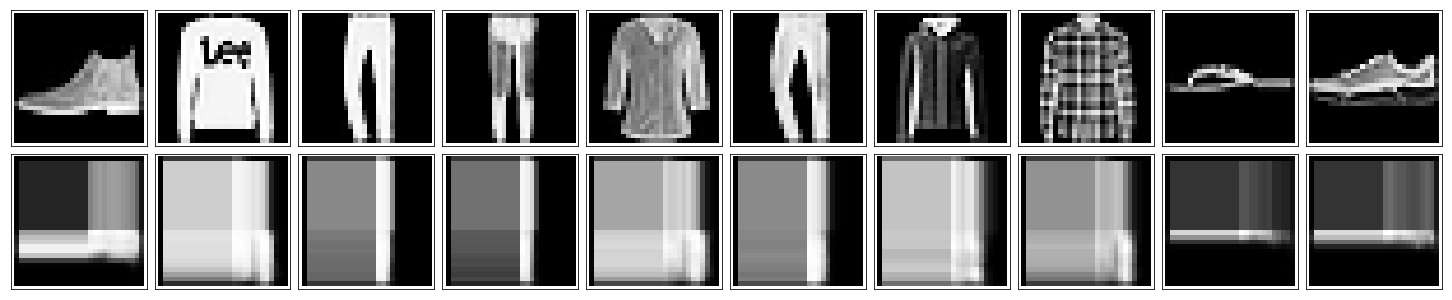

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = data.test.images[:10]

reconstructed = sess.run(decoded, feed_dict={inputs: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)